# Hands-on tutorial for DeiT-Ti

In this notebook, we show how to perform inference with a pre-trained DeiT-Ti

## Preliminaries

This section contains the necessary imports, installs and downloads necessary for the remaining of this notebook.

In [11]:
# DeiT is built on top of timm version 0.3.2, so need to install it first
!pip install timm
!pip install thop

# Clone DeiT repository
!git clone https://github.com/facebookresearch/deit.git

# Download ImageNet category names for nicer display
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

fatal: destination path 'deit' already exists and is not an empty directory.
--2023-11-30 17:07:35--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-11-30 17:07:35 (66.9 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [12]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
import timm
import torchvision
import torchvision.transforms as T
import thop
from thop import profile, clever_format
import torch.utils.data as Data
import torch.nn as nn
from deit.models import deit_tiny_patch16_224

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

torch.set_grad_enabled(False);

In [13]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('CUDA is available. Using GPU.')
else:
  device = torch.device('cpu')
  print('CUDA is not available. Using CPU')

CUDA is not available. Using CPU


In [14]:
# Read the ImageNet categories
with open("imagenet_classes.txt", "r") as f:
    imagenet_categories = [s.strip() for s in f.readlines()]

In [15]:
# create the data transform that DeiT expects
transform = T.Compose([
    T.Resize(256, interpolation=3),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

## Using a pre-trained model

In this section, we show how to load a pre-trained model and perform inference with it.

In [16]:
model = deit_tiny_patch16_224(pretrained=True)
model.eval();

Let's now retrieve an image from a url and return it as a PIL Image

In [47]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url2 = 'http://farm9.staticflickr.com/8476/8124445515_12fd44c5f9_z.jpg'
url3 = 'https://farm4.staticflickr.com/3805/9678067874_44b868ef4d_z.jpg'
url4 = 'https://live.staticflickr.com/4065/4364356125_27d8d952eb_c.jpg'
url5 = 'https://live.staticflickr.com/376/19949488151_1afdbae365_c.jpg'
cat = Image.open(requests.get(url, stream=True).raw)
horse = Image.open(requests.get(url2, stream=True).raw)
train = Image.open(requests.get(url3, stream=True).raw)
cuirass = Image.open(requests.get(url4, stream=True).raw)
hampter = Image.open(requests.get(url5, stream=True).raw)

Run one of these three!

In [29]:
img = cat

In [43]:
img = horse

In [33]:
img = train

In [39]:
img = cuirass

In [48]:
img = hampter

Preview the image.

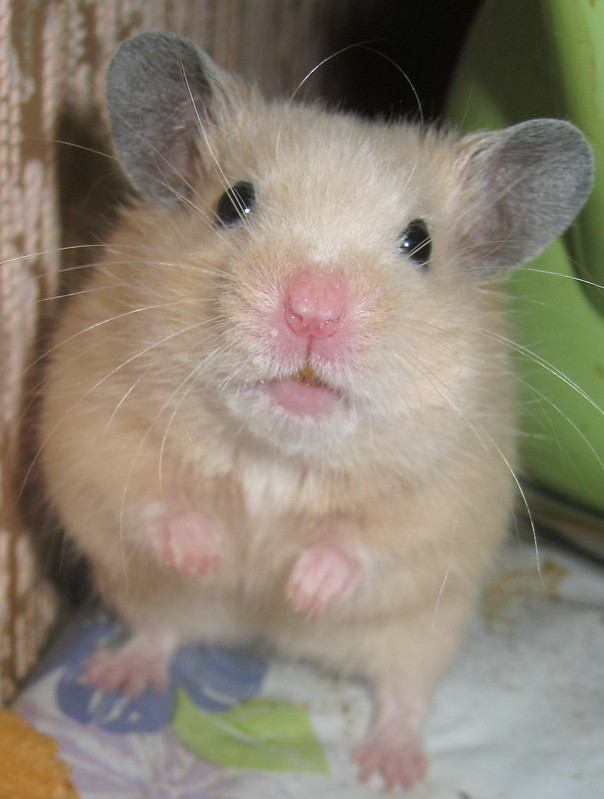

In [49]:
img

Next, we apply the preprocessing that DeiT expects during inference and run it through the model, computing the 5 classes with highest confidence.

In [50]:
# transform the original image and add a batch dimension
img = transform(img).unsqueeze(0)

img = img.to(device)
model = model.to(device)

In [51]:
# compute the predictions
out = model(img)

# and convert them into probabilities
scores = torch.nn.functional.softmax(out, dim=-1)[0]

# finally get the index of the prediction with highest score
topk_scores, topk_label = torch.topk(scores, k=5, dim=-1)

for i in range(5):
  pred_name = imagenet_categories[topk_label[i]]
  print(f"Prediction index {i}: {pred_name:<25}, score: {topk_scores[i].item():.3f}")

Prediction index 0: hamster                  , score: 0.766
Prediction index 1: Angora                   , score: 0.015
Prediction index 2: guinea pig               , score: 0.010
Prediction index 3: broccoli                 , score: 0.004
Prediction index 4: wood rabbit              , score: 0.002
